In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve

from cicyutils import CicyPad, StratifiedSampler
from cicyutils import pretty_print_results, analyze_knn_cv

# sklearn throws a warning when doing GridSearchCV due to some classes being
# sparsely populated. ignore this.

import warnings
warnings.filterwarnings('ignore')                                   

In [2]:
# Load the embeddings for the train and test sets 
x_train, y_train = np.load('x_e_tr.npy'), np.load('y_tr.npy')
x_test, y_test = np.load('x_e_te.npy'), np.load('y_te.npy')

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(210, 3) (210,)
(7681, 3) (7681,)


# K Nearest Neighbors Classifier

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score, matthews_corrcoef

### Tuning hyperparameters using Grid Search and Cross-Validation

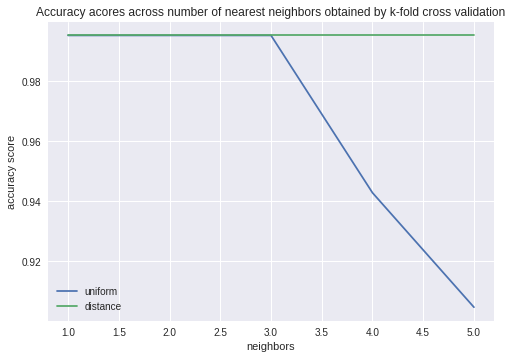

best parameters: {'knn Classifier__n_neighbors': 1, 'knn Classifier__weights': 'uniform'}


In [4]:
knn_pipeline = Pipeline([("knn Classifier", KNeighborsClassifier())])

param_grid = [{'knn Classifier__n_neighbors':list(range(1,6)), 
               'knn Classifier__weights': ['uniform', 'distance']}]

grid_search = GridSearchCV(knn_pipeline,param_grid,cv=5)

grid_search.fit(x_train,y_train)

cross_val_results = grid_search.cv_results_

analyze_knn_cv(cross_val_results)

print('best parameters:', grid_search.best_params_)

### ROC Curve

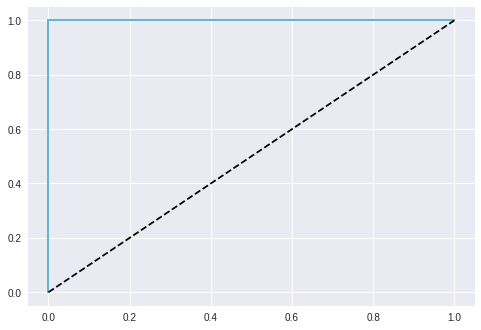

In [5]:
n_neighbors = grid_search.best_params_['knn Classifier__n_neighbors']
weights = grid_search.best_params_['knn Classifier__weights']

knn_pipeline_best = Pipeline([("knn Classifier", KNeighborsClassifier(n_neighbors=n_neighbors,weights=weights))])
knn_pipeline_best.fit(x_train,y_train)
y_proba = knn_pipeline_best.predict_proba(x_train)


fpr_list, tpr_list, threshold_list = [],[],[]

for i,y in enumerate(np.unique(y_train)):
    y_scores = y_proba[:,i] # see Pg 99 of Geron
    fpr,tpr,thresholds = roc_curve((y_train==y).astype(int),y_scores)
    plt.plot(fpr,tpr,linewidth=2)

plt.plot([0,1],[0,1],'k--')
plt.show()

### Fitting on to Test set

In [6]:
y_pred = knn_pipeline_best.predict(x_test)
print('accuracy score:', accuracy_score(y_test,y_pred))
print('matthews correlation coefficient:',matthews_corrcoef(y_test,y_pred))

accuracy score: 0.984767608384325
matthews correlation coefficient: 0.9825076188762684


In [7]:
pretty_print_results(y_test,y_pred)

+-----+-------------------+-------------+------------------+-------------+----------+-----------------------------------+
|   h |   test population |   predicted |   true positives |   precision |   recall |   percentage of test set isolated |
+=====+===================+=============+==================+=============+==========+===================================+
|   0 |                19 |          30 |                7 |        0.23 |     0.37 |                              0.39 |
+-----+-------------------+-------------+------------------+-------------+----------+-----------------------------------+
|   1 |                 2 |           4 |                2 |        0.5  |     1    |                              0.05 |
+-----+-------------------+-------------+------------------+-------------+----------+-----------------------------------+
|   2 |                33 |          45 |               33 |        0.73 |     1    |                              0.59 |
+-----+-----------------

### A comparable model

The grid search results suggest that n_neighbors = 4 and weights ='distance' should perform comparably 

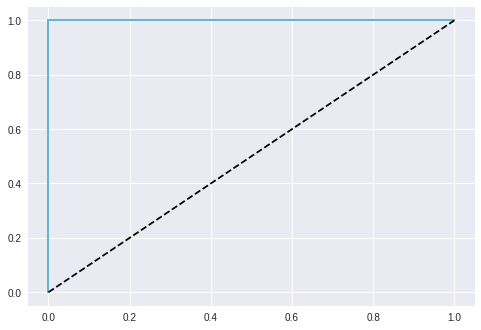

In [8]:
n_neighbors = 4
weights = 'distance'

knn_pipeline_best = Pipeline([("knn Classifier", KNeighborsClassifier(n_neighbors=n_neighbors,weights=weights))])
knn_pipeline_best.fit(x_train,y_train)
y_proba = knn_pipeline_best.predict_proba(x_train)


fpr_list, tpr_list, threshold_list = [],[],[]

for i,y in enumerate(np.unique(y_train)):
    y_scores = y_proba[:,i] # see Pg 99 of Geron
    fpr,tpr,thresholds = roc_curve((y_train==y).astype(int),y_scores)
    plt.plot(fpr,tpr,linewidth=2)

plt.plot([0,1],[0,1],'k--')
plt.show()

In [9]:
y_pred = knn_pipeline_best.predict(x_test)
print('accuracy score:', accuracy_score(y_test,y_pred))
print('matthews correlation coefficient:',matthews_corrcoef(y_test,y_pred))
pretty_print_results(y_test,y_pred)

accuracy score: 0.9851581825283167
matthews correlation coefficient: 0.9829559825837021
+-----+-------------------+-------------+------------------+-------------+----------+-----------------------------------+
|   h |   test population |   predicted |   true positives |   precision |   recall |   percentage of test set isolated |
+=====+===================+=============+==================+=============+==========+===================================+
|   0 |                19 |          31 |                8 |        0.26 |     0.42 |                              0.4  |
+-----+-------------------+-------------+------------------+-------------+----------+-----------------------------------+
|   1 |                 2 |           4 |                2 |        0.5  |     1    |                              0.05 |
+-----+-------------------+-------------+------------------+-------------+----------+-----------------------------------+
|   2 |                33 |          45 |               33